Very messy implementation of https://arxiv.org/pdf/2410.10103

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from src.generator import lorenz96
from src.koopman import *

# Causal Koopman

### Causal dependence with cumulative neighborhood shifts

We evaluate the spatial dependence. We attempt to reproduce Figures 7, 8 of the paper for Lorenz'96 dynamics.

In [3]:
# Integration
t0, t1 = 0.0, 10.0
dt = 0.001
steps = int((t1 - t0) / dt)

N = 101  # Number of sites / 'oscillators'
F = 4.0 
initial_state = F + jax.random.normal(jax.random.PRNGKey(42), shape=(N,))

# Solve the system
solver = diffrax.Dopri5()  # Runge-Kutta solver
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(lorenz96),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=initial_state,
    args=(F,),
    saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, min(4000, steps))),
    max_steps=100000
)

# Extract results
omega = solution.ys.T


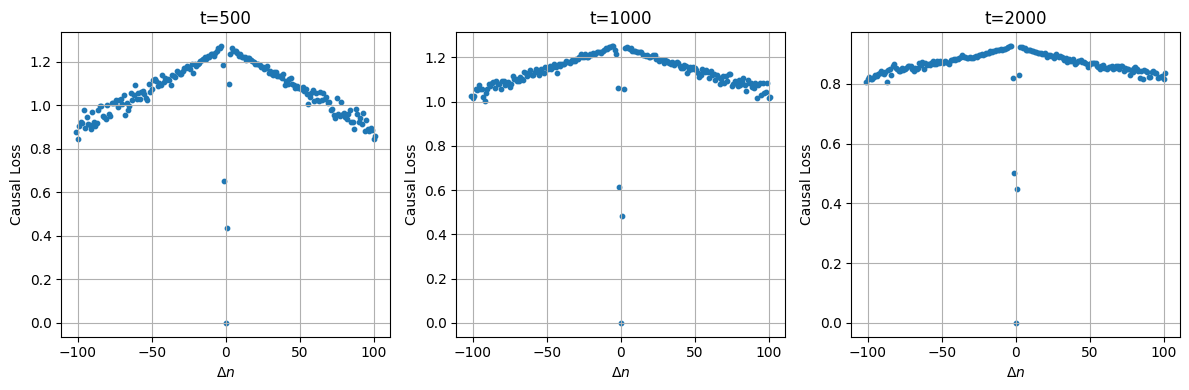

In [4]:
# Causal effect (cumulative neighborhood effect)
center_idx = 51
neighborhood_range = range(-N, N+1)
t_shifts = [500, 1000, 2000]

f, ax = plt.subplots(1, len(t_shifts), figsize=(12,4))

for i, t_shift in enumerate(t_shifts):
    
    # Effect
    effect = omega[center_idx:center_idx+1, :]

    # Compute causal loss with varying neighborhood ranges
    causal_losses = []
    
    for delta_n in neighborhood_range:
        
        ## Cause (cumulative neighborhood)
        if delta_n < 0:
            neighbor_indices = [(center_idx + i) % N for i in range(delta_n, 0)]
        
        else:
            neighbor_indices = [(center_idx + i) % N for i in range(1, delta_n + 1)]
    
        cause = omega[neighbor_indices, :]

        ## Compute causal loss
        causal_loss, _, _ = compute_causal_loss(
            cause, 
            effect, 
            t = t_shift
        )
        
        causal_losses.append(causal_loss)
    
    # Plot
    ax[i].scatter(neighborhood_range, causal_losses, s=10)
    ax[i].set_title(f't={int(t_shift)}')
    ax[i].grid()
    ax[i].set_xlabel(r"$\Delta n$")
    ax[i].set_ylabel("Causal Loss")

plt.tight_layout()
plt.show();
